# 1- Introdução

### Objetivo: Criar um forecast mensal para previsão de vendas de 4 produtos da Soft Horizon
* Esse projeto é baseado no forecast em Deep Learning que criei na minha empresa Gauge, onde é diariamente usado para prever o 
volume de vendas na sede da Vivo. Eu o criei sozinho desde o início adaptado ao nosso problema de negócio. Soft Horizon é uma empresa fictícia de tecnologia que criei para poder elaborar esse projeto aqui no Github e preservar os dados do cliente sem divulgação. O projeto original é bem mais complexo, e possui 42 canais prevendo diariamente o volume de vendas para 3 meses. Nesse projeto da Soft Horizon, farei algo mais simples, mas mantendo o intuito de prever as vendas do mês vigente.

### Modelo: Série temporal - Deep Learning - LSTM multivariable 

#### Produtos:
* Alpha_X - software de visualização de dados.
* Stark_Horizon - software de gravação musical.
* Magma_360 - Vídeo game
* Z_Ultron - Vídeo game

#### Etapas:
* 1 - Previsão de vendas mensal recebendo os dados diariamente (d-1)
* 2 - Criar um forecast automatizado que receba os dados do dia anterior e automaticamente subtraia 1 dia até o último dia do mês
* 3 - Salvar os dados no output no excel automaticamente nas pastas com as datas diariamente. 
* 4 - Que o forecast recebe os dados nomeado com a data, e automaticamente entenda e renomeie com a data atual.
* 5 - Criar os plots automaticamente com as datas nas pastas do dia e mês. 

#### Resumindo: receber os dados do dia anterior, rodar o modelo preditivo para previsão de vendas e gerar um output no excel que será enviado para o analista de BI gerar um relatório diário e dispará-lo para os gestores e tomadores de decisão. 


## 2 - Importando os pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ipy_table as tbl

from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from pandas import DataFrame
from pandas import concat

import datetime
from datetime import datetime, timedelta
from datetime import date, timedelta
import calendar

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style ("whitegrid")

Using TensorFlow backend.


## 3 - Data Wrangling

Automatizando os dados de entrada e criando pastas se não existirem, já nomeadas com o mês e dia.

In [2]:
import time
import os 
drive_letter = os.getcwd()
folder_name = r'\Input/'
folder_time_month = datetime.now().strftime("%Y-%m")
folder_to_save_files = drive_letter + folder_name + folder_time_month
if not os.path.exists(folder_to_save_files):
    os.mkdir(folder_to_save_files)

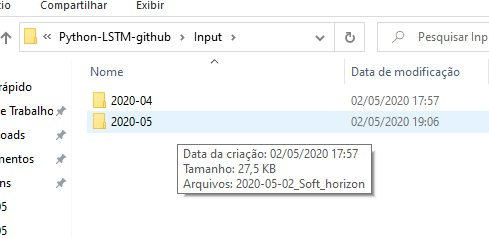

In [3]:
from IPython.display import Image
Image(filename='C:\Forecast\Python-LSTM-github/pastas.jpg') 

In [4]:
import datetime
filename = str(date.today()) + "_Soft_horizon.xlsx"
excel_file = (folder_to_save_files + "/" +  filename)
canais = pd.read_excel(excel_file, skiprows=0, format='%d/%m/%Y')
canais.head()

,Data,Alpha_X,Stark_Horizon,Magma_360,Z_Ultron
0,2019-01-01,239436,50685,9634,217436
1,2019-01-02,510305,188755,29948,488305
2,2019-01-03,524688,178090,27135,502688
3,2019-01-04,501017,188680,27547,479017
4,2019-01-05,381801,150390,17064,359801


In [5]:
canais['Data'] =  pd.to_datetime(canais['Data'], format='%d-%m-%Y')

In [6]:
canais = canais.set_index(['Data'])

In [7]:
from datetime import datetime
dias_atras31 = datetime.today() - timedelta(days=32) 

In [8]:
dias_atras31

datetime.datetime(2020, 4, 11, 23, 8, 45, 228239)

In [9]:
#último mês (lastMonth)
import datetime
today = datetime.date.today()
last_day_month = today.replace(day=4) #último dia do mês ou começo, isto é, data final 

In [10]:
# condicional para número de dias do mês
import calendar
import datetime
now = datetime.datetime.now()

if (calendar.monthrange(now.year, now.month)[1]) == 31: # 31 dias
    last_day_month
elif (calendar.monthrange(now.year, now.month)[1]) == 29: # 29 dias
    last_day_month = last_day_month - timedelta(days=2)
elif (calendar.monthrange(now.year, now.month)[1]) == 28: # 28 dias
    last_day_month = last_day_month - timedelta(days=3)
else:
    last_day_month = last_day_month - timedelta(days=1) # 30 dias

In [11]:
last_day_month

datetime.date(2020, 5, 4)

## 4 - Criando range de datas e novas colunas

In [12]:
first_date = pd.Timestamp('2019-01-01')
split_date = pd.Timestamp(dias_atras31)
split_date1 = pd.Timestamp(dias_atras31)
final_date = pd.Timestamp(last_day_month)
total =  canais
canais_date1 = canais.loc[first_date:split_date]
canais_date2 = canais.loc[split_date1:final_date]

In [13]:
canais1 = canais_date1
canais2 = canais_date2 

In [14]:
from datetime import datetime
data = pd.date_range(start = datetime(2019,1,1),end = dias_atras31, freq = 'D')

data = pd.DataFrame(data)
data.columns = ['Data']

data['day'] = data['Data'].map(lambda x: x.day)

data['month'] = data['Data'].map(lambda x: x.month)

data['year'] = data['Data'].map(lambda x: x.year)

data['weekday'] = data['Data'].map(lambda x: x.weekday())

data['weekyear'] = data['Data'].map(lambda x: x.strftime("%V"))
data['weekyear'] = data['weekyear'].map(lambda x: int(x))

data['week_of_month'] = data['Data'].map(lambda x: (x.day-1)//7+1)

data['monday'] = data['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x<1 else 1
data['monday'] = data['monday'].map(y)

data['tuesday'] = data['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x==1 else 1
data['tuesday'] = data['tuesday'].map(y)

data['wednesday'] = data['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x==2 else 1
data['wednesday'] = data['wednesday'].map(y)

data['thursday'] = data['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x==3 else 1
data['thursday'] = data['thursday'].map(y)

data['friday'] = data['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x==4 else 1
data['friday'] = data['friday'].map(y)

data['saturday'] = data['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x==5 else 1
data['saturday'] = data['saturday'].map(y)

data['sunday'] = data['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x>5 else 1
data['sunday'] = data['sunday'].map(y)

data['weekend'] = data['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x>4 else 1
data['weekend'] = data['weekend'].map(y)

data.drop(["Data"], axis=1, inplace= True )

In [15]:
data.index = data.index + 1

In [16]:
from datetime import datetime
start_range = datetime.today() - timedelta(days=32)

range_dt = pd.date_range(start = start_range, end = last_day_month, freq = 'D')
#range_dt = pd.date_range(start="04/01/2020", end="07/01/2020", freq = 'D')
range_dt = pd.DataFrame(range_dt)
range_dt.columns = ['Data']

range_dt['day'] = range_dt['Data'].map(lambda x: x.day)

range_dt['month'] = range_dt['Data'].map(lambda x: x.month)

range_dt['year'] = range_dt['Data'].map(lambda x: x.year)

range_dt['weekday'] = range_dt['Data'].map(lambda x: x.weekday())

range_dt['weekyear'] = range_dt['Data'].map(lambda x: x.strftime("%V"))
range_dt['weekyear'] = range_dt['weekyear'].map(lambda x: int(x))

range_dt['week_of_month'] = range_dt['Data'].map(lambda x: (x.day-1)//7+1)

range_dt['monday'] = range_dt['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x<1 else 1
range_dt['monday'] = range_dt['monday'].map(y)

range_dt['tuesday'] = range_dt['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x==1 else 1
range_dt['tuesday'] = range_dt['tuesday'].map(y)

range_dt['wednesday'] = range_dt['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x==2 else 1
range_dt['wednesday'] = range_dt['wednesday'].map(y)

range_dt['thursday'] = range_dt['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x==3 else 1
range_dt['thursday'] = range_dt['thursday'].map(y)

range_dt['friday'] = range_dt['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x==4 else 1
range_dt['friday'] = range_dt['friday'].map(y)

range_dt['saturday'] = range_dt['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x==5 else 1
range_dt['saturday'] = range_dt['saturday'].map(y)

range_dt['sunday'] = range_dt['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x>5 else 1
range_dt['sunday'] = range_dt['sunday'].map(y)

range_dt['weekend'] = range_dt['Data'].map(lambda x: x.weekday())
y = lambda x: 2 if x>4 else 1
range_dt['weekend'] = range_dt['weekend'].map(y)

range_dt_date = range_dt["Data"]

In [17]:
range_dt.drop(["Data"], axis=1, inplace= True )
range_dt.index = range_dt.index + 1

In [18]:
range_dt # novas colunas de treino

,day,month,year,weekday,weekyear,week_of_month,monday,tuesday,wednesday,thursday,friday,saturday,sunday,weekend
1,11,4,2020,5,15,2,1,1,1,1,1,2,1,2
2,12,4,2020,6,15,2,1,1,1,1,1,1,2,2
3,13,4,2020,0,16,2,2,1,1,1,1,1,1,1
4,14,4,2020,1,16,2,1,2,1,1,1,1,1,1
5,15,4,2020,2,16,3,1,1,2,1,1,1,1,1
6,16,4,2020,3,16,3,1,1,1,2,1,1,1,1
7,17,4,2020,4,16,3,1,1,1,1,2,1,1,1
8,18,4,2020,5,16,3,1,1,1,1,1,2,1,2
9,19,4,2020,6,16,3,1,1,1,1,1,1,2,2
10,20,4,2020,0,17,3,2,1,1,1,1,1,1,1


## 5 - Criando o modelo preditivo

In [19]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [20]:
canais1 = canais1.reset_index(drop=True)
canais2 = canais2.reset_index(drop=True)

### Alpha_X

(465, 1, 15) (465,) (21, 1, 15) (21,)
Total atual =  7642449.0
Total previsto =  6796654.15625
Diferença =  -845794.84375


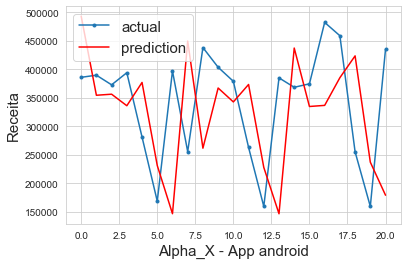

In [21]:
bigdata = pd.concat([canais1["Alpha_X"], data], axis=1)
bigdata2 = pd.concat([canais2["Alpha_X"], range_dt], axis=1)
bigdata2 = bigdata2.dropna()

values = bigdata.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1)
reframed.drop(reframed.columns[[16,17,18,19,20,21,22,23,24,25,26,27,28,29]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
values = reframed.values

values2 = bigdata2.values
values2 = values2.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values2)
reframed2 = series_to_supervised(scaled, 1)
reframed2.drop(reframed2.columns[[16,17,18,19,20,21,22,23,24,25,26,27,28,29]], axis=1, inplace=True)
#reframed2.drop(reframed2.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
values2 = reframed2.values
train = values
test = values2

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.rcParams["figure.figsize"] = (6,4)
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.ylabel('Receita', size=15)
plt.xlabel('Alpha_X - App android', size=15)
plt.legend(fontsize=15)

print("Total atual = ",sum(bigdata2["Alpha_X"]))
print("Total previsto = ",sum(inv_yhat))
print("Diferença = ",(sum(inv_yhat)) - (sum(bigdata2["Alpha_X"])))
var1 = (sum(inv_yhat)) - (sum(bigdata2["Alpha_X"]))
inv_yhat1 = inv_yhat

In [22]:
bigdata2 # apenas visualizando o dataset usado no predict

,Alpha_X,day,month,year,weekday,weekyear,week_of_month,monday,tuesday,wednesday,thursday,friday,saturday,sunday,weekend
1,435509.0,11.0,4.0,2020.0,5.0,15.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0
2,386022.0,12.0,4.0,2020.0,6.0,15.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
3,389759.0,13.0,4.0,2020.0,0.0,16.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,372834.0,14.0,4.0,2020.0,1.0,16.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
5,394127.0,15.0,4.0,2020.0,2.0,16.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0
6,281023.0,16.0,4.0,2020.0,3.0,16.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
7,168344.0,17.0,4.0,2020.0,4.0,16.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
8,397164.0,18.0,4.0,2020.0,5.0,16.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0
9,255394.0,19.0,4.0,2020.0,6.0,16.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
10,438317.0,20.0,4.0,2020.0,0.0,17.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Stark Horizon

(465, 1, 15) (465,) (21, 1, 15) (21,)
Total atual =  3083460.0
Total previsto =  2625066.1796875
Diferença =  -458393.8203125


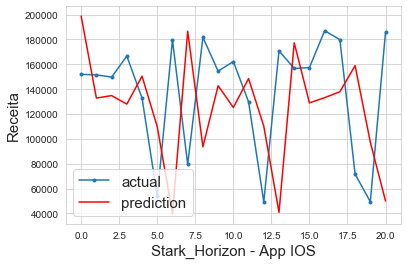

In [23]:
bigdata = pd.concat([canais1["Stark_Horizon"], data], axis=1)
bigdata2 = pd.concat([canais2["Stark_Horizon"], range_dt], axis=1)
bigdata2 = bigdata2.dropna()

values = bigdata.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1)
reframed.drop(reframed.columns[[16,17,18,19,20,21,22,23,24,25,26,27,28,29]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
values = reframed.values

values2 = bigdata2.values
values2 = values2.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values2)
reframed2 = series_to_supervised(scaled, 1)
reframed2.drop(reframed2.columns[[16,17,18,19,20,21,22,23,24,25,26,27,28,29]], axis=1, inplace=True)
#reframed2.drop(reframed2.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
values2 = reframed2.values
train = values
test = values2

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.rcParams["figure.figsize"] = (6,4)
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.ylabel('Receita', size=15)
plt.xlabel('Stark_Horizon - App IOS', size=15)
plt.legend(fontsize=15)

print("Total atual = ",sum(bigdata2["Stark_Horizon"]))
print("Total previsto = ",sum(inv_yhat))
print("Diferença = ",(sum(inv_yhat)) - (sum(bigdata2["Stark_Horizon"])))
var2 = (sum(inv_yhat)) - (sum(bigdata2["Stark_Horizon"]))
inv_yhat2 = inv_yhat

### Magma 360

(465, 1, 15) (465,) (21, 1, 15) (21,)
Total atual =  362877.0
Total previsto =  346099.05615234375
Diferença =  -16777.94384765625


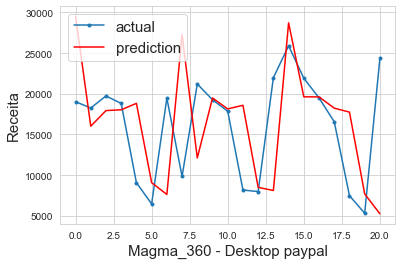

In [24]:
bigdata = pd.concat([canais1["Magma_360"], data], axis=1)
bigdata2 = pd.concat([canais2["Magma_360"], range_dt], axis=1)
bigdata2 = bigdata2.dropna()

values = bigdata.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1)
reframed.drop(reframed.columns[[16,17,18,19,20,21,22,23,24,25,26,27,28,29]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
values = reframed.values

values2 = bigdata2.values
values2 = values2.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values2)
reframed2 = series_to_supervised(scaled, 1)
reframed2.drop(reframed2.columns[[16,17,18,19,20,21,22,23,24,25,26,27,28,29]], axis=1, inplace=True)
#reframed2.drop(reframed2.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
values2 = reframed2.values
train = values
test = values2

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.rcParams["figure.figsize"] = (6,4)
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.ylabel('Receita', size=15)
plt.xlabel('Magma_360 - Desktop paypal', size=15)
plt.legend(fontsize=15)

print("Total atual = ",sum(bigdata2["Magma_360"]))
print("Total previsto = ",sum(inv_yhat))
print("Diferença = ",(sum(inv_yhat)) - (sum(bigdata2["Magma_360"])))
var3 = (sum(inv_yhat)) - (sum(bigdata2["Magma_360"]))
inv_yhat3 = inv_yhat

### Z Ultron

(465, 1, 15) (465,) (21, 1, 15) (21,)
Total atual =  7159549.0
Total previsto =  6355476.3203125
Diferença =  -804072.6796875


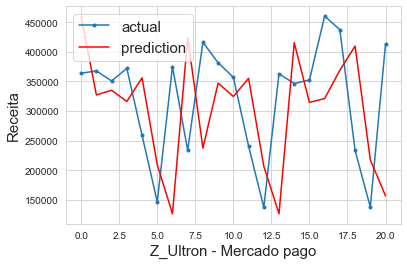

In [25]:
bigdata = pd.concat([canais1["Z_Ultron"], data], axis=1)
bigdata2 = pd.concat([canais2["Z_Ultron"], range_dt], axis=1)
bigdata2 = bigdata2.dropna()

values = bigdata.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1)
reframed.drop(reframed.columns[[16,17,18,19,20,21,22,23,24,25,26,27,28,29]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
values = reframed.values

values2 = bigdata2.values
values2 = values2.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values2)
reframed2 = series_to_supervised(scaled, 1)
reframed2.drop(reframed2.columns[[16,17,18,19,20,21,22,23,24,25,26,27,28,29]], axis=1, inplace=True)
#reframed2.drop(reframed2.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
values2 = reframed2.values
train = values
test = values2

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

plt.rcParams["figure.figsize"] = (6,4)
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.ylabel('Receita', size=15)
plt.xlabel('Z_Ultron - Mercado pago', size=15)
plt.legend(fontsize=15)

print("Total atual = ",sum(bigdata2["Z_Ultron"]))
print("Total previsto = ",sum(inv_yhat))
print("Diferença = ",(sum(inv_yhat)) - (sum(bigdata2["Z_Ultron"])))
var4 = (sum(inv_yhat)) - (sum(bigdata2["Z_Ultron"]))
inv_yhat4 = inv_yhat

## 6 - Gerando o output

In [26]:
# tem que alterar mensalmente ( adiciona 30 ou 31 dias para performar o mês seguinte)
append_next_month = pd.DateOffset(days=31)

# range de datas para filtrar
import calendar
valores_mes = pd.DataFrame()
valores_mes['Data'] = pd.date_range(start='01-Jan-2018', end='31-Dec-2022', freq='D')  
valores_mes.set_index('Data', inplace=True)

# quantidade de dias no mês atual
days_list = []
for val in valores_mes.index:
    days_list.append(calendar.monthrange(val.year, val.month)[1])

valores_mes['days_in_month'] = days_list

parcial = pd.concat([canais, valores_mes], axis=1) # concatena canais e valores mes
parcial.reset_index(level=0, inplace=True)

# range de datas correntes
import datetime
today = datetime.date.today() 
start_date = today.replace(day=1) # primeiro dia do mês
end_date = datetime.date.today()-timedelta(days=1) # d menos 1

after_start_date = parcial["Data"] >= start_date
before_end_date = parcial["Data"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_dates = parcial.loc[between_two_dates]

canais_date2.reset_index(level=0, inplace=True)
base = range_dt_date
base = base.to_frame(name='Data')
base = base.drop([0, 0]) 

In [27]:
input_Alpha_X = filtered_dates[["Data","Alpha_X"]]
input_Alpha_X.rename(columns={"Alpha_X":'valor'},inplace=True)
input_Stark_Horizon = filtered_dates[["Data","Stark_Horizon"]]
input_Stark_Horizon.rename(columns={"Stark_Horizon":'valor'},inplace=True)
input_Magma_360 = filtered_dates[["Data","Magma_360"]]
input_Magma_360.rename(columns={"Magma_360":'valor'},inplace=True)
input_Z_Ultron = filtered_dates[["Data","Z_Ultron"]]
input_Z_Ultron.rename(columns={"Z_Ultron":'valor'},inplace=True)

Aqui há a manipulação dos dados onde os valores realizados são juntados aos valores preditos. No caso, hoje 13 de Maio de 2020 temos os dados realizados até d-1. De hoje até o dia 31 de Maio de 2020 os valores são os preditos. 

In [28]:
valor = pd.DataFrame(data=inv_yhat1)
valor= valor.shift(-1, axis = 0) #subir valores 1 linha p/cima (necessário pra acertar fim de semana e dias da semana no excel)
valor = valor.drop([0, 0])
output_Alpha_X = pd.concat([base, valor], axis=1) 
output_Alpha_X["Data"] =  output_Alpha_X["Data"] + append_next_month # somar dias às datas para performar o mês seguinte
output_Alpha_X = output_Alpha_X.dropna()
output_Alpha_X.rename(columns={0:'valor'},inplace=True)
append_Alpha_X = input_Alpha_X.append(output_Alpha_X)
append_Alpha_X.reset_index(level=0, inplace=True)
append_Alpha_X.drop(["index"], axis=1, inplace= True )
finish_Alpha_X = pd.concat([append_Alpha_X], axis=1)
finish_Alpha_X["id"] = "Alpha_X"
finish_Alpha_X["canal"] = "Data Visualization"
finish_Alpha_X = finish_Alpha_X.dropna()

valor = pd.DataFrame(data=inv_yhat2) 
valor= valor.shift(-1, axis = 0)
valor = valor.drop([0, 0]) 
output_Stark_Horizon = pd.concat([base, valor], axis=1) 
output_Stark_Horizon["Data"] =  output_Stark_Horizon["Data"] + append_next_month 
output_Stark_Horizon = output_Stark_Horizon.dropna()
output_Stark_Horizon.rename(columns={0:'valor'},inplace=True)
append_Stark_Horizon = input_Stark_Horizon.append(output_Stark_Horizon)
append_Stark_Horizon.reset_index(level=0, inplace=True)
append_Stark_Horizon.drop(["index"], axis=1, inplace= True )
finish_Stark_Horizon = pd.concat([append_Stark_Horizon], axis=1)
finish_Stark_Horizon["id"] = "Stark_Horizon"
finish_Stark_Horizon["canal"] = "Musical Software"
finish_Stark_Horizon = finish_Stark_Horizon.dropna()

valor = pd.DataFrame(data=inv_yhat3) 
valor= valor.shift(-1, axis = 0)
valor = valor.drop([0, 0]) 
output_Magma_360 = pd.concat([base, valor], axis=1) 
output_Magma_360["Data"] =  output_Magma_360["Data"] + append_next_month 
output_Magma_360 = output_Magma_360.dropna()
output_Magma_360.rename(columns={0:'valor'},inplace=True)
append_Magma_360 = input_Magma_360.append(output_Magma_360)
append_Magma_360.reset_index(level=0, inplace=True)
append_Magma_360.drop(["index"], axis=1, inplace= True )
finish_Magma_360 = pd.concat([append_Magma_360], axis=1)
finish_Magma_360["id"] = "Magma_360"
finish_Magma_360["canal"] =  "Games"
finish_Magma_360 = finish_Magma_360.dropna()

valor = pd.DataFrame(data=inv_yhat4) 
valor= valor.shift(-1, axis = 0)
valor = valor.drop([0, 0]) 
output_Z_Ultron = pd.concat([base, valor], axis=1) 
output_Z_Ultron["Data"] =  output_Z_Ultron["Data"] + append_next_month 
output_Z_Ultron = output_Z_Ultron.dropna()
output_Z_Ultron.rename(columns={0:'valor'},inplace=True)
append_Z_Ultron = input_Z_Ultron.append(output_Z_Ultron)
append_Z_Ultron.reset_index(level=0, inplace=True)
append_Z_Ultron.drop(["index"], axis=1, inplace= True )
finish_Z_Ultron = pd.concat([append_Z_Ultron], axis=1)
finish_Z_Ultron["id"] = "Z_Ultron"
finish_Z_Ultron["canal"] =  "Games"
finish_Z_Ultron = finish_Z_Ultron.dropna()

In [29]:
result = finish_Alpha_X.append([finish_Stark_Horizon,finish_Magma_360,finish_Z_Ultron])
result["nome_modelo"] = "LSTM"
result = result.round()
result = result.astype({"valor": int})

In [30]:
result['data'] = result['Data'].dt.date # excluir timestamp e manter formato padrão de data
result = result.drop("Data", axis=1)
result = result[['id','canal','data','nome_modelo', 'valor' ]]
result

,id,canal,data,nome_modelo,valor
0,Alpha_X,Data Visualization,2020-05-01,LSTM,459133
1,Alpha_X,Data Visualization,2020-05-02,LSTM,255043
2,Alpha_X,Data Visualization,2020-05-03,LSTM,159003
3,Alpha_X,Data Visualization,2020-05-04,LSTM,435509
4,Alpha_X,Data Visualization,2020-05-05,LSTM,386622
...,...,...,...,...,...
26,Z_Ultron,Games,2020-05-27,LSTM,321020
27,Z_Ultron,Games,2020-05-28,LSTM,369119
28,Z_Ultron,Games,2020-05-29,LSTM,409856
29,Z_Ultron,Games,2020-05-30,LSTM,217376


Gerando automaticamente a pasta output e nomeando o arquivo com a data atual

In [31]:
from datetime import datetime
name0 = datetime.strptime(str(date.today()), '%Y-%m-%d').strftime('%Y%m%d')
name = name0+ "_soft_horizon.xlsx"

In [32]:
name # nome do arquivo de output gerado na pasta com a data de hoje

'20200513_soft_horizon.xlsx'

In [33]:
from datetime import datetime
import time 
import os 
drive_letter = os.getcwd()
folder_output = r'/Output/'
folder_time = datetime.now().strftime("%Y-%m")
folder_to_save_output =  drive_letter + folder_output + folder_time
if not os.path.exists(folder_to_save_output):
    os.mkdir(folder_to_save_output)

In [34]:
result.to_excel(folder_to_save_output +"/"+ name, index = False)

In [35]:
# salvar na pasta plots
from datetime import datetime
import time
import os 
drive_letter = os.getcwd()
folder_plots = r'\Plots/'
folder_time_month_plots = datetime.now().strftime("%Y-%m")
folder_time_day_plots = datetime.now().strftime("%Y-%m-%d")
folder_to_save_plots = drive_letter + folder_plots + folder_time_month_plots
folder_to_save_plots_day = drive_letter + folder_plots + folder_time_month_plots +"/" + folder_time_day_plots
# IF no such folder exists, create one automatically
if not os.path.exists(folder_to_save_plots):
    os.mkdir(folder_to_save_plots)  
# IF no such folder exists, create one automatically
if not os.path.exists(folder_to_save_plots_day):
    os.mkdir(folder_to_save_plots_day) 

In [36]:
# função para o plot
import datetime
today = datetime.date.today() 
end_date = today.replace(day=1) - timedelta(days=1) # primeiro dia do mês - 1. (último dia mês passado)
start_date = end_date - timedelta(days=180) # último dia do mês passado menos 180 dias.

after_start_date = parcial["Data"] >= start_date
before_end_date = parcial["Data"] <= end_date
between_two_dates = after_start_date & before_end_date
filtered_graf = parcial.loc[between_two_dates]

## 7 - Resultado

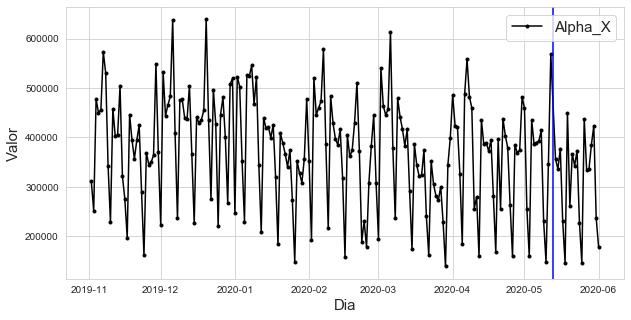

In [37]:
filtered_graf1 = filtered_graf[["Alpha_X","Data"]]  
filtered_graf1.rename(columns={"Alpha_X":'valor'},inplace=True)
finish_Alpha_X = finish_Alpha_X[["valor","Data"]]
plot_Alpha_X = filtered_graf1.append(finish_Alpha_X)
plot_Alpha_X = plot_Alpha_X.set_index(['Data'])
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(plot_Alpha_X, 'k-', marker='.', label = 'Alpha_X')
plt.axvline(x=today,c = 'b')
plt.ylabel('Valor', size=15)
plt.xlabel('Dia', size=15)
plt.legend(fontsize=15)
plt.savefig(folder_to_save_plots_day + '/Alpha_X.png')
#plt.close()

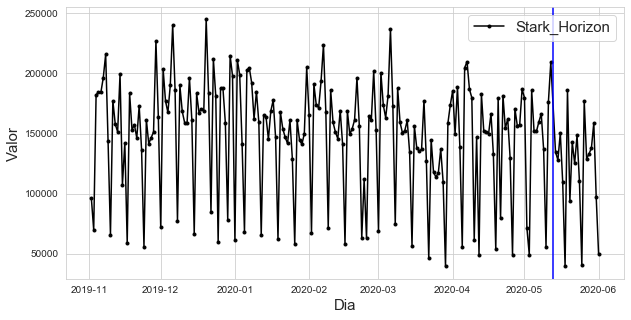

In [38]:
filtered_graf2 = filtered_graf[["Stark_Horizon","Data"]]
filtered_graf2.rename(columns={"Stark_Horizon":'valor'},inplace=True)
finish_Stark_Horizon = finish_Stark_Horizon[["valor","Data"]]
plot_Stark_Horizon = filtered_graf2.append(finish_Stark_Horizon)
plot_Stark_Horizon = plot_Stark_Horizon.set_index(['Data'])
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(plot_Stark_Horizon, 'k-', marker='.', label = 'Stark_Horizon')
plt.axvline(x=today,c = 'b')
plt.ylabel('Valor', size=15)
plt.xlabel('Dia', size=15)
plt.legend(fontsize=15)
plt.savefig(folder_to_save_plots_day + '/Stark_Horizon.png')
#plt.close()

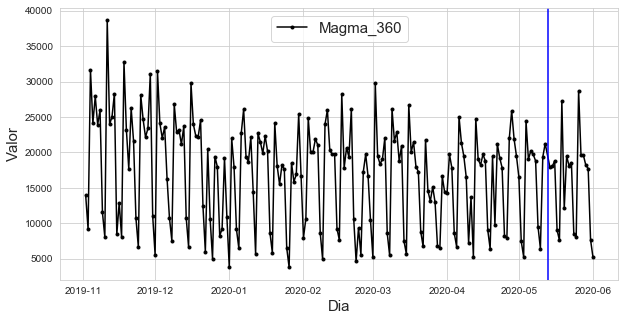

In [39]:
filtered_graf3 = filtered_graf[["Magma_360","Data"]]
filtered_graf3.rename(columns={"Magma_360":'valor'},inplace=True)
finish_Magma_360 = finish_Magma_360[["valor","Data"]]
plot_Magma_360 = filtered_graf3.append(finish_Magma_360)
plot_Magma_360 = plot_Magma_360.set_index(['Data'])
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(plot_Magma_360, 'k-', marker='.', label = 'Magma_360')
plt.axvline(x=today,c = 'b')
plt.ylabel('Valor', size=15)
plt.xlabel('Dia', size=15)
plt.legend(fontsize=15)
plt.savefig(folder_to_save_plots_day + '/Magma_360.png')
#plt.close()

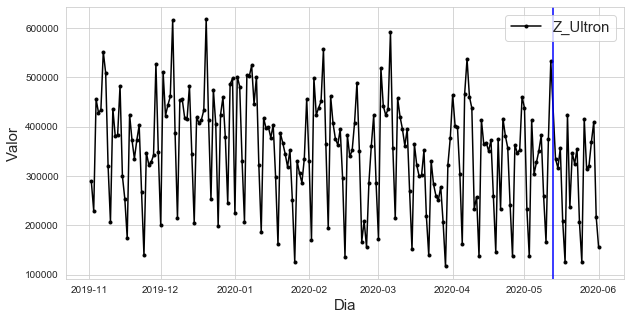

In [40]:
filtered_graf4 = filtered_graf[["Z_Ultron","Data"]]
filtered_graf4.rename(columns={"Z_Ultron":'valor'},inplace=True)
finish_Z_Ultron = finish_Z_Ultron[["valor","Data"]]
plot_Z_Ultron = filtered_graf4.append(finish_Z_Ultron)
plot_Z_Ultron = plot_Z_Ultron.set_index(['Data'])
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(plot_Z_Ultron, 'k-', marker='.', label = 'Z_Ultron')
plt.axvline(x=today,c = 'b')
plt.ylabel('Valor', size=15)
plt.xlabel('Dia', size=15)
plt.legend(fontsize=15)
plt.savefig(folder_to_save_plots_day + '/Z_Ultron.png')
#plt.close()

In [41]:
Total_var_dias_restantes = var1+var2+var3+var4

In [47]:
Total_var_dias_restantes # próximos x dias até o fim do mês prevê uma queda ou aumento dê... em relação ao mês anterior

-2125039.2875976562

In [50]:
Alpha_X = result[result.id.str.contains('Alpha_X',case=False)]
Stark_Horizon = result[result.id.str.contains('Stark_Horizon',case=False)]
Magma_360 = result[result.id.str.contains('Magma_360',case=False)]
Z_Ultron = result[result.id.str.contains('Z_Ultron',case=False)]

In [51]:
results = [
    ["Receita Alpha_X: R$", Alpha_X["valor"].values.sum()],
    ["Receita Stark Horizon : R$", Stark_Horizon["valor"].values.sum()],
    ["Receita Magma_360: R$", Magma_360["valor"].values.sum()],
    ["Receita Z_Ultron: R$", Z_Ultron["valor"].values.sum()],
    ]
tbl.make_table(results)

Receita Alpha_X: R$,10135855
Receita Stark Horizon : R$,3988616
Receita Magma_360: R$,488719
Receita Z_Ultron: R$,9488361


In [52]:
print("Receita Total: R$",result["valor"].values.sum())

Receita Total: R$ 24101551


In [53]:
print("Forecast concluído")

Forecast concluído


## 8 - Conclusão

* O modelo gerou predição de vendas para os 4 produtos para o restante do mês
* O valor total de receita para o mês de Maio da Soft Horizon segundo a previsão será aproximadamente de R$ 24.101.551 
* O output do modelo foi salvo na pasta "Output" no formato xlsx, tendo o histórico para cada dia nomeado pela data.
* Os plots foram salvos na pasta Plot, tendo o histórico para cada dia nomeado pela data.
* O modelo está automatizado, e compreende o "today", e a cada dia que passa, está somando o realizado com os dias restantes previstos.
